In [34]:
from manifold_learning import IMD, CCM
from manifold_learning.utils import utils
import importlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.integrate import solve_ivp
importlib.reload(IMD)
importlib.reload(utils)

<module 'manifold_learning.utils.utils' from '/home/iaroslav/Documents/Python projects/manifold_learning/src/manifold_learning/utils/utils.py'>

In [26]:
def lorenz(t, state, sigma, beta, rho):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

In [27]:
def get_lorenz_rand(tmax = 140, n_steps = 10000, sigma=10, beta=8/3, rho=28):
    initial_state = np.random.normal(size=(3))

    trunc = int(n_steps/tmax * 40) # Number of steps to get independence from initial conditions
    t_eval = np.linspace(0, tmax, trunc + n_steps)

    solution = solve_ivp(lorenz, (0, tmax), initial_state, args=(sigma, beta, rho), t_eval=t_eval).y.T[trunc:]
    return solution

In [28]:
X = np.array([np.sin(np.linspace(0,200/((i+1)*0.1337),20000)) for i in range(5)]).sum(axis=0)[:,None]
X_emb = utils.get_td_embedding_np(X,40,2,return_pred=False)[:,:,0]
#X_emb = X_emb @ np.random.normal(0,1,(30,100))
X_emb = StandardScaler().fit_transform(X_emb)

In [28]:
X = np.array([get_lorenz_rand(280,n_steps=30000)[:,0] for i in range(5)])
X = X.T @ np.random.uniform(-1,1,(5,10))
X_emb = utils.get_td_embedding_np(X,4,20,return_pred=False)
X_emb = X_emb.reshape(X_emb.shape[0],-1)
X_emb = StandardScaler().fit_transform(X_emb)

In [29]:
trainer = IMD.IMD_nD(X_emb.shape[1], embed_dim=3, n_components=5,subtract_corr=True, device="cuda")

In [49]:
trainer.fit(X_emb, sample_len=700, library_len=2000, 
            exclusion_rad=50, nbrs_num=10, tp=64, 
            epochs=1000, num_batches=1,optimizer="Adam", learning_rate=0.001,tp_policy="range")


Epoch 1/1000, Loss: 0.9630
Epoch 2/1000, Loss: 0.9616
Epoch 3/1000, Loss: 0.9622
Epoch 4/1000, Loss: 0.9614
Epoch 5/1000, Loss: 0.9593
Epoch 6/1000, Loss: 0.9586
Epoch 7/1000, Loss: 0.9577
Epoch 8/1000, Loss: 0.9561
Epoch 9/1000, Loss: 0.9577
Epoch 10/1000, Loss: 0.9577
Epoch 11/1000, Loss: 0.9528
Epoch 12/1000, Loss: 0.9556
Epoch 13/1000, Loss: 0.9531
Epoch 14/1000, Loss: 0.9533
Epoch 15/1000, Loss: 0.9548
Epoch 16/1000, Loss: 0.9519
Epoch 17/1000, Loss: 0.9509
Epoch 18/1000, Loss: 0.9475
Epoch 19/1000, Loss: 0.9512
Epoch 20/1000, Loss: 0.9488
Epoch 21/1000, Loss: 0.9462
Epoch 22/1000, Loss: 0.9439
Epoch 23/1000, Loss: 0.9422
Epoch 24/1000, Loss: 0.9416
Epoch 25/1000, Loss: 0.9418
Epoch 26/1000, Loss: 0.9438
Epoch 27/1000, Loss: 0.9414
Epoch 28/1000, Loss: 0.9411
Epoch 29/1000, Loss: 0.9420
Epoch 30/1000, Loss: 0.9388
Epoch 31/1000, Loss: 0.9402
Epoch 32/1000, Loss: 0.9412
Epoch 33/1000, Loss: 0.9405
Epoch 34/1000, Loss: 0.9408
Epoch 35/1000, Loss: 0.9417
Epoch 36/1000, Loss: 0.9396
E

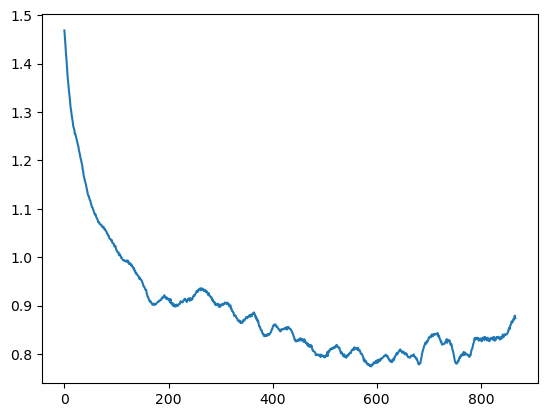

In [45]:
plt.plot(trainer.get_loss_history()[:])


In [46]:

unmixed = trainer.predict(X_emb)

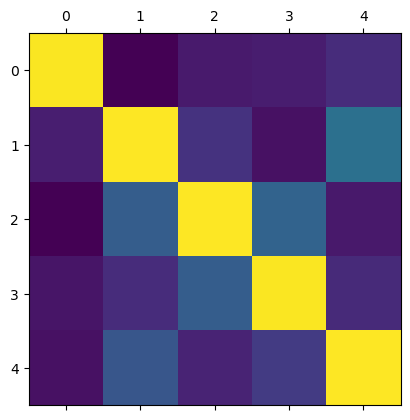

In [47]:
ccm = CCM.CCM(device="cpu")
plt.matshow(ccm.compute(np.transpose(unmixed,(1,0,2)), np.transpose(unmixed,(1,0,2)), 500, 150, 20, 10, 0).mean(axis=0))

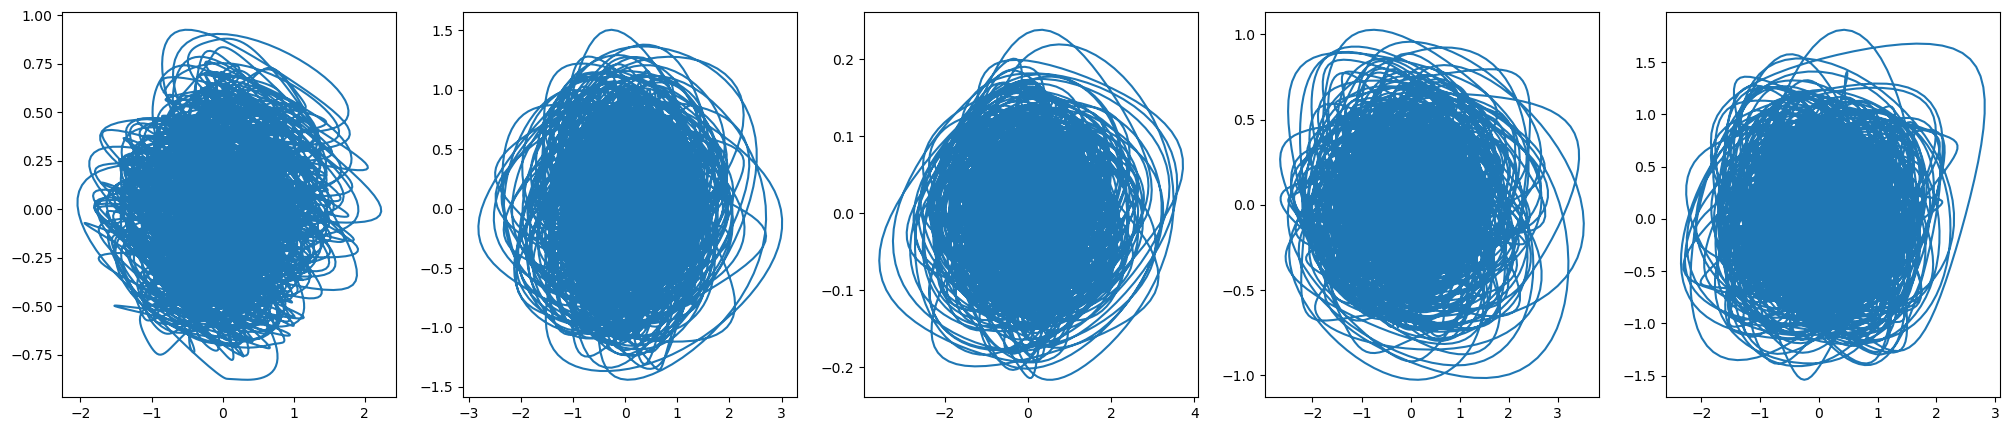

In [48]:
plt.figure(figsize=(5*unmixed.shape[1],5))
for i in range(unmixed.shape[1]):
    plt.subplot(1,unmixed.shape[1],i+1)
    x_pca = PCA(2).fit_transform(unmixed[:,i,:])
    plt.plot(x_pca[:,0],x_pca[:,1])

In [43]:
import plotly.express as px
fig = px.line_3d(x=unmixed[:,1,0], y=unmixed[:,1,1],z=unmixed[:,1,2],height=700)

fig.show()